<a href="https://colab.research.google.com/github/hw3092-create/Project-1-Frog-Tail/blob/main/Project_1_Frog_Tail_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%pip -q install -U condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [1]:

!mamba install -y -c conda-forge \
  python=3.11 \
  numpy=1.26.4 scipy=1.11.4 pandas=2.2.2 matplotlib=3.8.4 \
  scikit-learn=1.4.2 anndata=0.10.7 scanpy=1.10.2 umap-learn=0.5.6 \
  h5py=3.10 igraph python-igraph leidenalg openpyxl


Looking for: ['python=3.11', 'numpy=1.26.4', 'scipy=1.11.4', 'pandas=2.2.2', 'matplotlib=3.8.4', 'scikit-learn=1.4.2', 'anndata=0.10.7', 'scanpy=1.10.2', 'umap-learn=0.5.6', 'h5py=3.10', 'igraph', 'python-igraph', 'leidenalg', 'openpyxl']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   2%
conda-forge/noarch     3%[+] 0.3s
conda-forge/linux-64   5%
conda-forge/noarch    34%[+] 0.4s
conda-forge/linux-64  15%
conda-forge/noarch    54%[+] 0.5s
conda-forge/linux-64  16%
conda-forge/noarch    57%[+] 0.6s
conda-forge/linux-64  19%
conda-forge/noarch    63%[+] 0.7s
conda-forge/linux-64  22%
conda-forge/noarch    69%[+] 0.8s
conda-forge/linux-64  25%
conda-forge/noarch    75%[+] 0.9s
conda-forge/linux-64  28%
conda-forge/noarch    78%[+] 1.0s
conda-forge/linux-64  29%
conda-forge/noarch    84%[+] 1.1s
conda-forge/linux-64  32%
conda-forge/noarch    90%[+] 1.2s
conda-forge/linux-64  35%
cond

In [2]:
import numpy as np, scipy, anndata, pandas as pd, sklearn, matplotlib
import scanpy as sc
print("NumPy", np.__version__,
      "| SciPy", scipy.__version__,
      "| anndata", anndata.__version__,
      "| sklearn", sklearn.__version__,
      "| matplotlib", matplotlib.__version__,
      "| scanpy", sc.__version__)

NumPy 1.26.4 | SciPy 1.11.4 | anndata 0.10.7 | sklearn 1.4.2 | matplotlib 3.8.4 | scanpy 1.10.2


In [5]:
import os, glob, numpy as np, pandas as pd, scanpy as sc, scipy.sparse as sp


os.makedirs("data/raw", exist_ok=True)
h5_cands = glob.glob("data/raw/*.h5ad") + glob.glob("*.h5ad")
assert h5_cands, "Upload cleaned_processed_frogtail.h5ad to data/raw/ first."
h5_path = h5_cands[0]
print("Using:", h5_path)

adata = sc.read_h5ad(h5_path)
print(adata)

def sanitize_X(adata, clip_q=0.999):
    X = adata.X
    if sp.issparse(X):
        d = X.data
        bad = ~np.isfinite(d)
        if bad.any(): d[bad] = 0.0
        if d.size:
            hi = np.quantile(d[np.isfinite(d)], clip_q)
            d[d > hi] = hi
        adata.X.data = d
    else:
        arr = np.asarray(X, dtype=np.float32, order="C")
        arr[~np.isfinite(arr)] = 0.0
        if np.isfinite(arr).any():
            hi = np.nanquantile(arr, clip_q)
            arr[arr > hi] = hi
        adata.X = arr

sanitize_X(adata)
cell_ok = np.isfinite(np.array(adata.X.sum(axis=1)).ravel())
gene_ok = np.isfinite(np.array(adata.X.sum(axis=0)).ravel())
adata = adata[cell_ok, :][:, gene_ok].copy()
print("After sanitize:", adata.shape)

Using: cleaned_processed_frogtail.h5ad


/usr/local/lib/python3.12/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'
After sanitize: (13199, 31535)


{'need_norm': False}


/tmp/ipython-input-2272474374.py:55: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_proc, resolution=1.0, key_added="clusters_leiden")


{'silhouette_leiden': 0.149, 'silhouette_gmm': 0.173, 'AMI': 0.712, 'ARI': 0.402, 'gmm_K': 16}


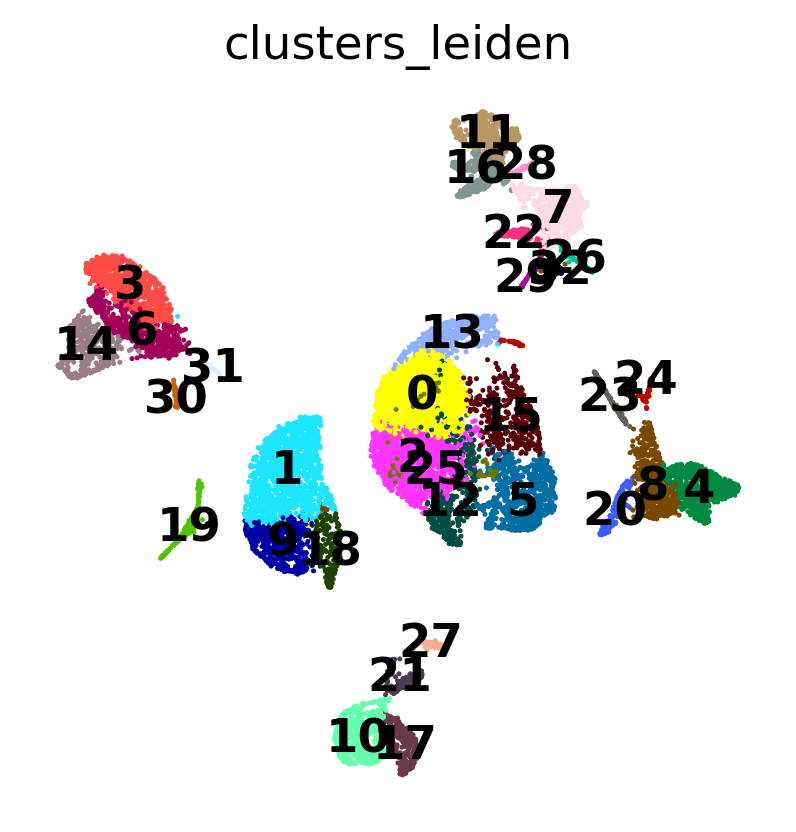

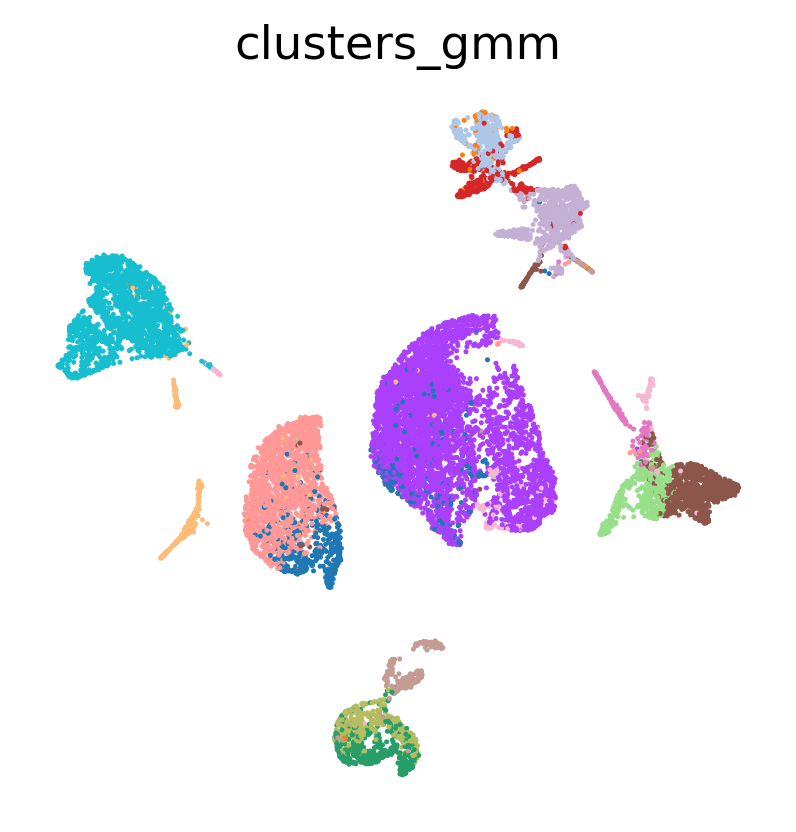

Saved: figures/umap_leiden.png, figures/umap_gmm.png, figures/cluster_metrics.csv


In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score

sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.settings.figdir = "figures"
os.makedirs("figures", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)


X = adata.X
if sp.issparse(X):
    samp = X.data[: min(100_000, X.data.size)]
else:
    flat = X.ravel()
    samp = flat[np.random.choice(flat.size, size=min(100_000, flat.size), replace=False)]
need_norm = (np.mean(np.isclose(samp, np.round(samp))) > 0.95) and (np.median(samp) >= 1.5)
print({"need_norm": bool(need_norm)})

adata_proc = adata.copy()
if need_norm:
    sc.pp.filter_genes(adata_proc, min_cells=3)
    sc.pp.normalize_total(adata_proc, target_sum=1e4)
    sc.pp.log1p(adata_proc)


try:
    sc.pp.highly_variable_genes(adata_proc, flavor='cell_ranger', n_top_genes=3000, subset=True)
except Exception as e:
    print("HVG cell_ranger failed, variance fallback:", e)
    if sp.issparse(adata_proc.X):
        mean0 = np.array(adata_proc.X.mean(axis=0)).ravel()
        mean2 = np.array(adata_proc.X.power(2).mean(axis=0)).ravel()
        var = mean2 - mean0**2
    else:
        var = adata_proc.X.var(axis=0)
    var = np.nan_to_num(var, nan=0.0, posinf=0.0, neginf=0.0)
    top = np.argsort(var)[-min(3000, var.size):]
    adata_proc = adata_proc[:, top].copy()


if 'total_counts' not in adata_proc.obs:
    adata_proc.obs['total_counts'] = np.array(adata_proc.X.sum(axis=1)).ravel()
if 'pct_counts_mt' not in adata_proc.obs:
    adata_proc.obs['pct_counts_mt'] = 0.0
import statsmodels
sc.pp.regress_out(adata_proc, keys=['total_counts'])
sc.pp.scale(adata_proc, max_value=10)


sc.pp.pca(adata_proc, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata_proc, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata_proc)


sc.tl.leiden(adata_proc, resolution=1.0, key_added="clusters_leiden")


X_pca = adata_proc.obsm['X_pca'][:, :20]
Ks = list(range(8, 17))
bics = []
for k in Ks:
    try:
        g = GaussianMixture(n_components=k, covariance_type='full', random_state=0).fit(X_pca)
        bics.append(g.bic(X_pca))
    except Exception:
        bics.append(np.inf)
K_best = Ks[int(np.argmin(bics))]
gmm = GaussianMixture(n_components=K_best, covariance_type='full', random_state=0).fit(X_pca)
adata_proc.obs['clusters_gmm'] = gmm.predict(X_pca).astype(str)


sil_leiden = silhouette_score(X_pca, adata_proc.obs['clusters_leiden'].astype(str))
sil_gmm    = silhouette_score(X_pca, adata_proc.obs['clusters_gmm'].astype(str))
ami        = adjusted_mutual_info_score(adata_proc.obs['clusters_leiden'], adata_proc.obs['clusters_gmm'])
ari        = adjusted_rand_score(adata_proc.obs['clusters_leiden'], adata_proc.obs['clusters_gmm'])
print({"silhouette_leiden": round(sil_leiden,3),
       "silhouette_gmm": round(sil_gmm,3),
       "AMI": round(ami,3), "ARI": round(ari,3),
       "gmm_K": int(K_best)})


sc.pl.umap(adata_proc, color=["clusters_leiden"], legend_loc="on data", frameon=False, save="_leiden.png")
sc.pl.umap(adata_proc, color=["clusters_gmm"],   legend_loc=None,    frameon=False, save="_gmm.png")
pd.DataFrame([{
    "silhouette_leiden": round(sil_leiden,3),
    "silhouette_gmm": round(sil_gmm,3),
    "AMI(leiden,gmm)": round(ami,3),
    "ARI(leiden,gmm)": round(ari,3),
    "gmm_K": int(K_best),
    "n_cells": adata_proc.n_obs,
    "n_genes(HVG)": adata_proc.n_vars
}]).to_csv("figures/cluster_metrics.csv", index=False)
adata_proc.write_h5ad("data/processed/adata_clustered.h5ad")
print("Saved: figures/umap_leiden.png, figures/umap_gmm.png, figures/cluster_metrics.csv")

ROC candidate (skin-restricted): 18


/tmp/ipython-input-2917540747.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cs = adataC.obs.groupby(cluster_key)[[c for c in adataC.obs.columns if c.startswith("score_")]].mean().sort_index()


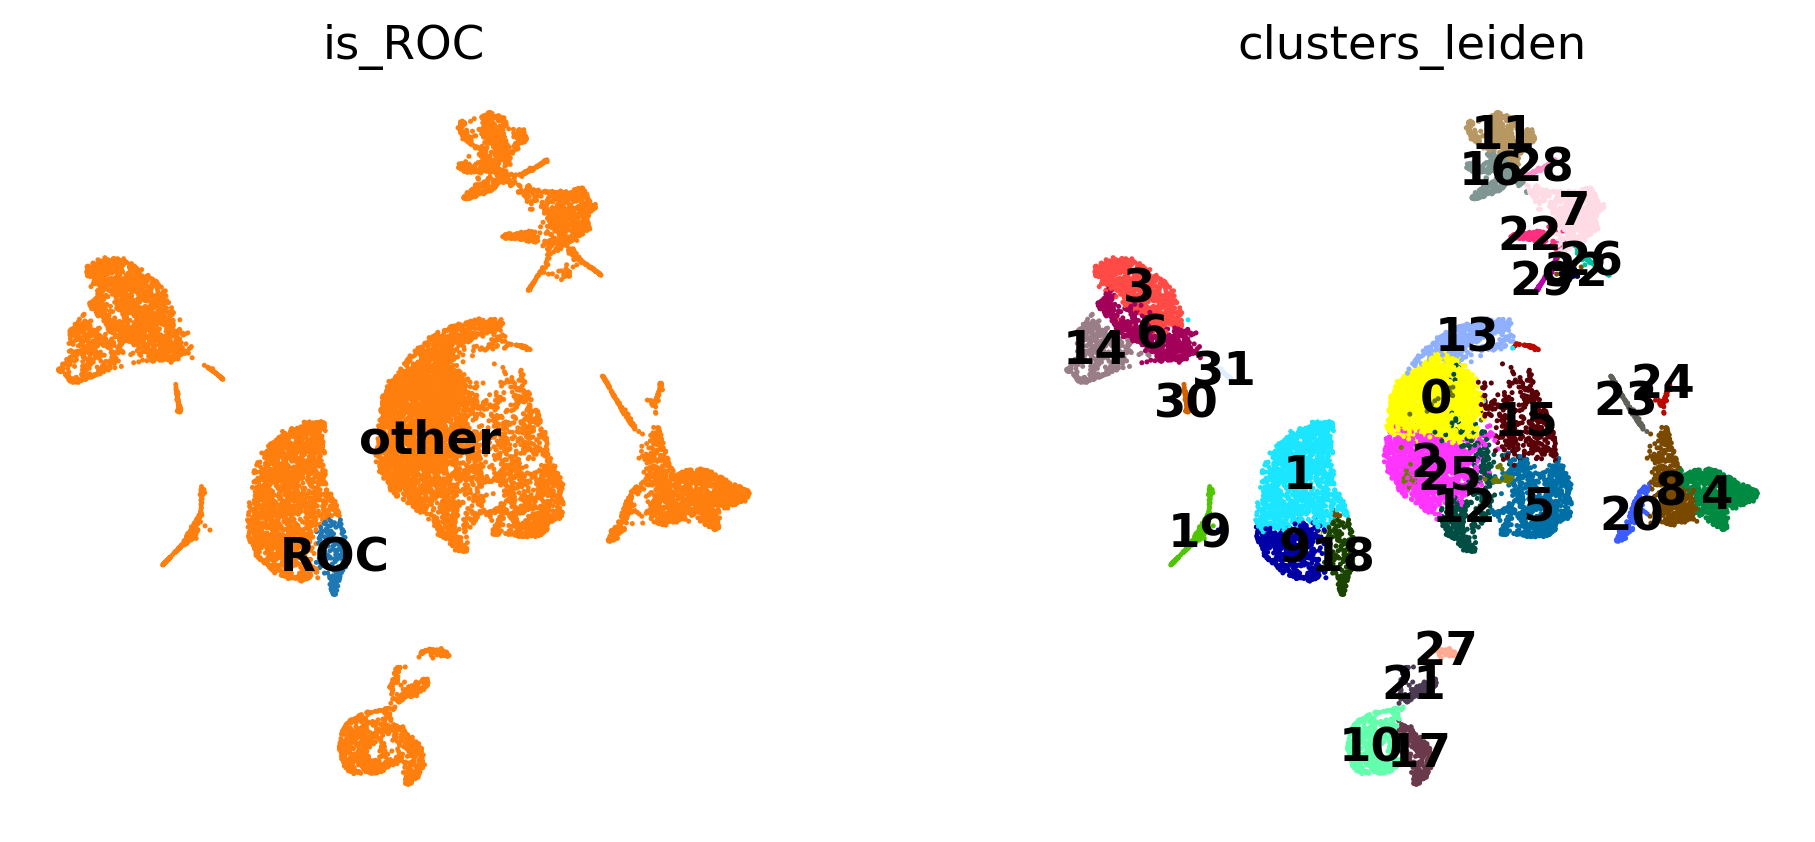

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: 

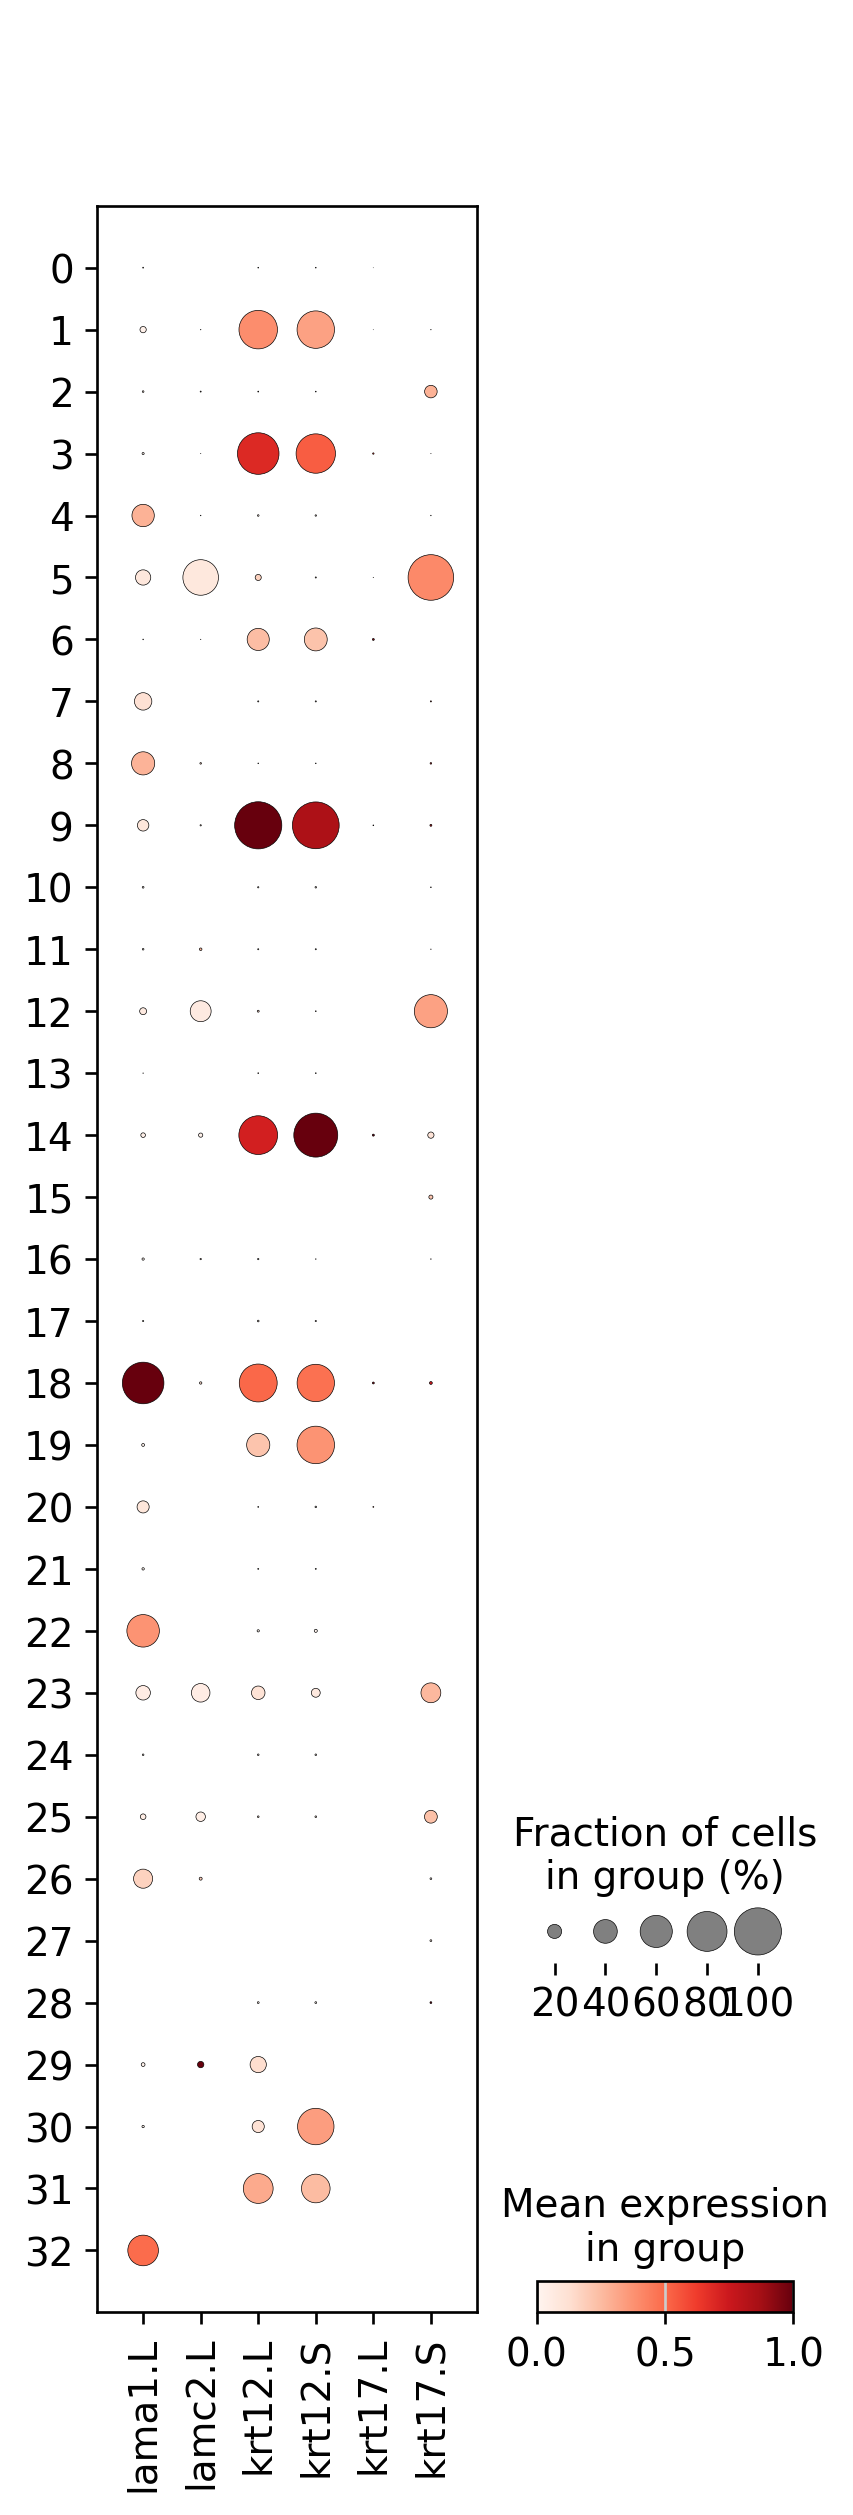

Saved ROC figs & CSVs in figures/ and data/processed/


In [7]:
import re
adataC = sc.read_h5ad("data/processed/adata_clustered.h5ad")
cluster_key = "clusters_leiden"

V = pd.Index(adataC.var_names)
def find_present(symbols):
    hits=[]
    for s in symbols:
        rx = re.compile(rf"(^|[_\.]){re.escape(s)}([_\.\b]|$)", re.IGNORECASE)
        hits += [g for g in V if rx.search(g)]
    return sorted(set(hits))

EPIDERMAL = ['krt8','krt18','krt19','krt12','krt15','krt17','epcam','cldn1','tp63']
LAMININ   = ['lama1','lama3','lama5','lamb1','lamb3','lamc1','lamc2']
INTEGRIN  = ['itga6','itga3','itgb1','itgb4']
NEURAL    = ['mbp','olig2','sox10','elavl3','neurod1']
MUSCLE    = ['myh1','myh6','tnnt2','acta1','myod1']
RBC       = ['hbbe1','hba','hbb','hbae1']

panels = { 'Epidermal': find_present(EPIDERMAL),
           'Laminin':   find_present(LAMININ),
           'Integrin':  find_present(INTEGRIN),
           'Neural':    find_present(NEURAL),
           'Muscle':    find_present(MUSCLE),
           'RBC':       find_present(RBC), }
for name, genes in panels.items():
    if genes: sc.tl.score_genes(adataC, gene_list=genes, score_name=f'score_{name}', use_raw=False)
    else:     adataC.obs[f'score_{name}'] = 0.0

cs = adataC.obs.groupby(cluster_key)[[c for c in adataC.obs.columns if c.startswith("score_")]].mean().sort_index()
epi = cs['score_Epidermal']; lam = cs['score_Laminin']; integ = cs['score_Integrin']
penalty = cs['score_Neural'] + cs['score_Muscle'] + cs['score_RBC']
cands = cs.index[epi >= np.quantile(epi, 0.75)]
if len(cands)==0: cands = cs.index
score = lam.loc[cands] + 0.5*integ.loc[cands] - 0.3*penalty.loc[cands]
roc_cluster = score.sort_values(ascending=False).index[0]
print("ROC candidate (skin-restricted):", roc_cluster)

adataC.obs['is_ROC'] = np.where(adataC.obs[cluster_key].astype(str)==str(roc_cluster), 'ROC', 'other')
sc.pl.umap(adataC, color=['is_ROC', cluster_key], frameon=False, legend_loc='on data',
           save="_ROC_highlight_skinrestricted.png")

sc.tl.rank_genes_groups(adataC, groupby=cluster_key, method='wilcoxon', n_genes=300)
wx_df = sc.get.rank_genes_groups_df(adataC, group=str(roc_cluster)).dropna()
wx_df.to_csv("data/processed/roc_markers_wilcoxon.csv", index=False)

sc.tl.rank_genes_groups(adataC, groupby=cluster_key, method='logreg', n_genes=300, key_added='rank_logreg')
lr_df = sc.get.rank_genes_groups_df(adataC, group=str(roc_cluster), key='rank_logreg').dropna()
lr_df.to_csv("data/processed/roc_markers_logreg.csv", index=False)


preferred = panels['Laminin'][:4] + panels['Integrin'][:4] + panels['Epidermal'][:4]
preferred = [g for g in preferred if g in adataC.var_names]
fallback  = list(wx_df['names'].head(8))
show = (preferred[:8] or fallback)[:8]
sc.pl.dotplot(adataC, var_names=show, groupby=cluster_key, standard_scale='var',
              save="_ROC_markers_skinrestricted.png")

adataC.write_h5ad("data/processed/adata_with_ROC.h5ad")
print("Saved ROC figs & CSVs in figures/ and data/processed/")

silhouette (PCA recon, r=20): 0.22


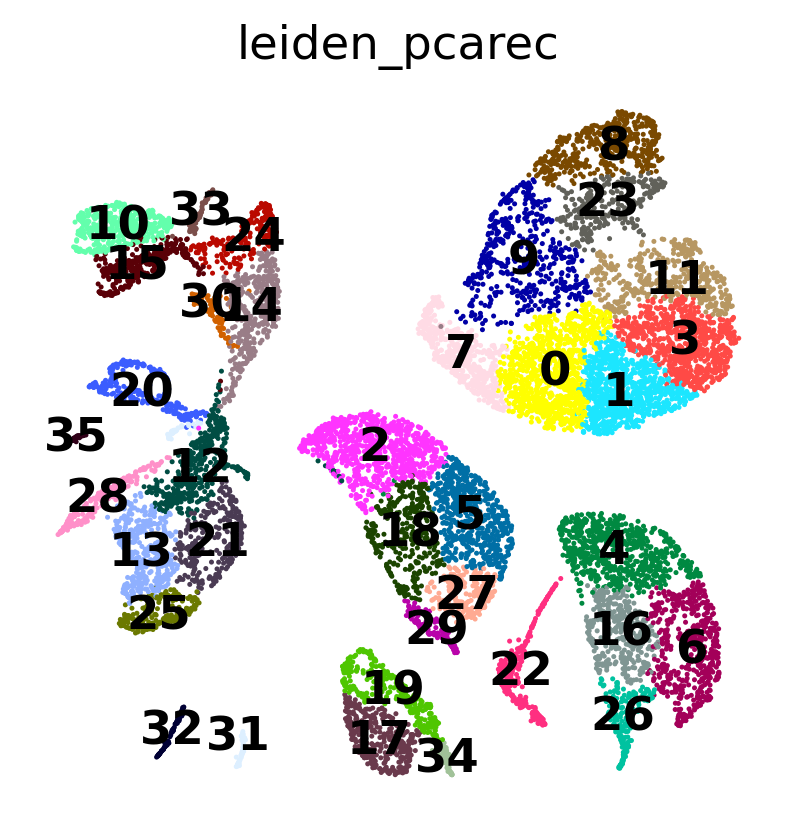

silhouette (kNN smooth): 0.145


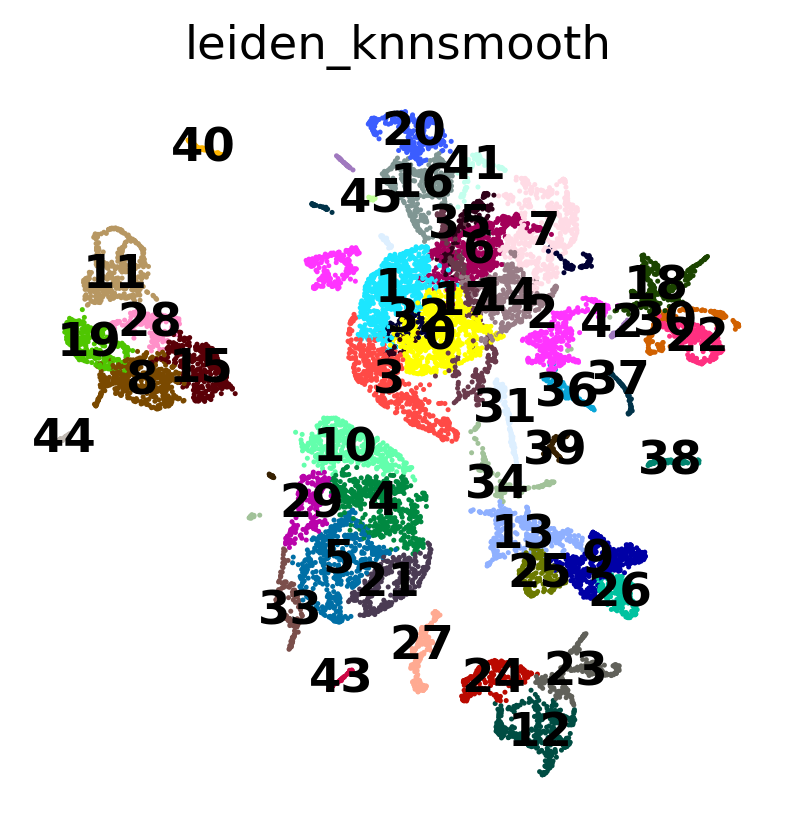

In [10]:
from sklearn.metrics import silhouette_score
from scipy.sparse import diags

BASE = sc.read_h5ad("data/processed/adata_clustered.h5ad").copy()

def pca_recon(A, r=20):
    B = A.copy()
    S = B.obsm['X_pca'][:, :r]
    L = B.varm['PCs'][:, :r]
    B.X = S @ L.T
    return B


den_pcarec = pca_recon(BASE, r=20)
sc.pp.pca(den_pcarec, n_comps=50); sc.pp.neighbors(den_pcarec, n_neighbors=15, n_pcs=50)
sc.tl.umap(den_pcarec); sc.tl.leiden(den_pcarec, resolution=1.0, key_added="leiden_pcarec")
sil_pcarec = silhouette_score(den_pcarec.obsm['X_pca'][:, :20], den_pcarec.obs['leiden_pcarec'].astype(str))
print("silhouette (PCA recon, r=20):", round(sil_pcarec,3))
sc.pl.umap(den_pcarec, color="leiden_pcarec", legend_loc="on data", frameon=False, save="_denoise_pcarec20.png")

den_knn = BASE.copy()
sc.pp.neighbors(den_knn, n_neighbors=15, n_pcs=50)
W = den_knn.obsp['connectivities'].tocsr()
row_sum = np.array(W.sum(axis=1)).ravel(); row_sum[row_sum==0] = 1.0
Wn = diags(1.0/row_sum).dot(W)
den_knn.X = Wn.dot(den_knn.X)

sc.pp.pca(den_knn, n_comps=50); sc.pp.neighbors(den_knn, n_neighbors=15, n_pcs=50)
sc.tl.umap(den_knn); sc.tl.leiden(den_knn, resolution=1.0, key_added="leiden_knnsmooth")
sil_knn = silhouette_score(den_knn.obsm['X_pca'][:, :20], den_knn.obs['leiden_knnsmooth'].astype(str))
print("silhouette (kNN smooth):", round(sil_knn,3))
sc.pl.umap(den_knn, color="leiden_knnsmooth", legend_loc="on data", frameon=False, save="_denoise_knnsmooth.png")

In [12]:
!mamba install -y -c conda-forge bbknn=1.6.0


Looking for: ['bbknn=1.6.0']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
Your pinning does not match what's currently installed. Please remove the pin and fix your installation
  Pin: python=3.12
  Currently installed: conda-forge/linux-64::python==3.11.11=h9e4cc4f_1_cpython


BBKNN not found — installing into this kernel…


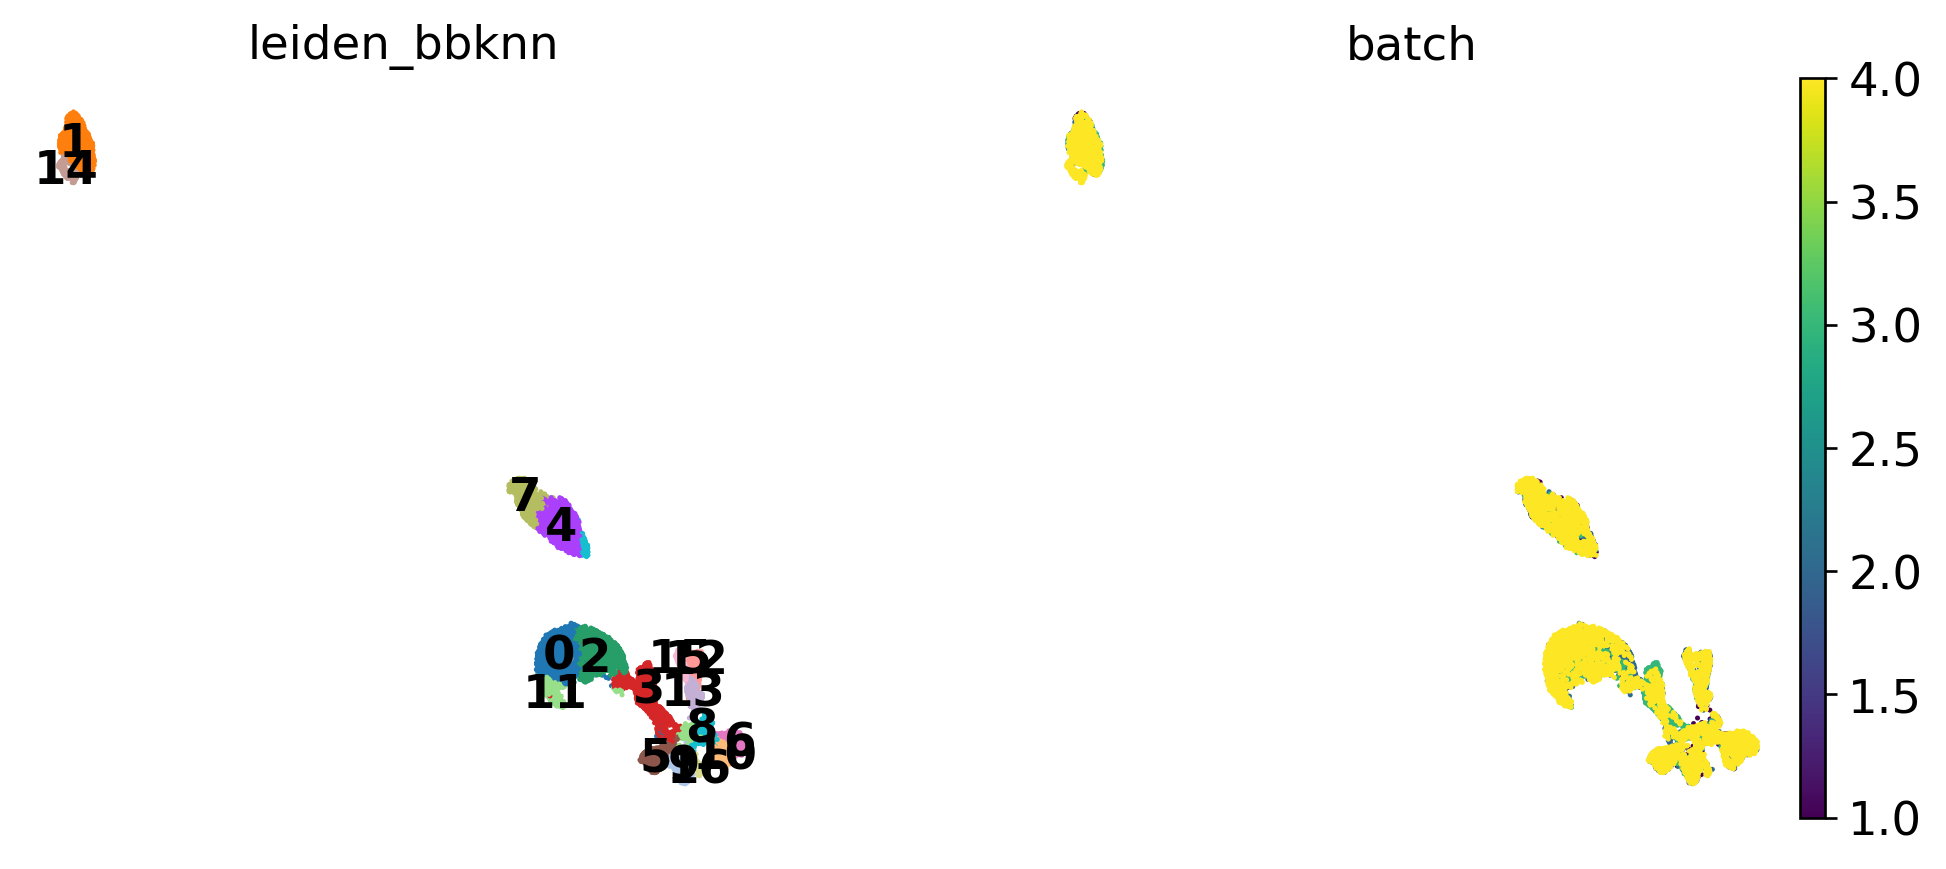

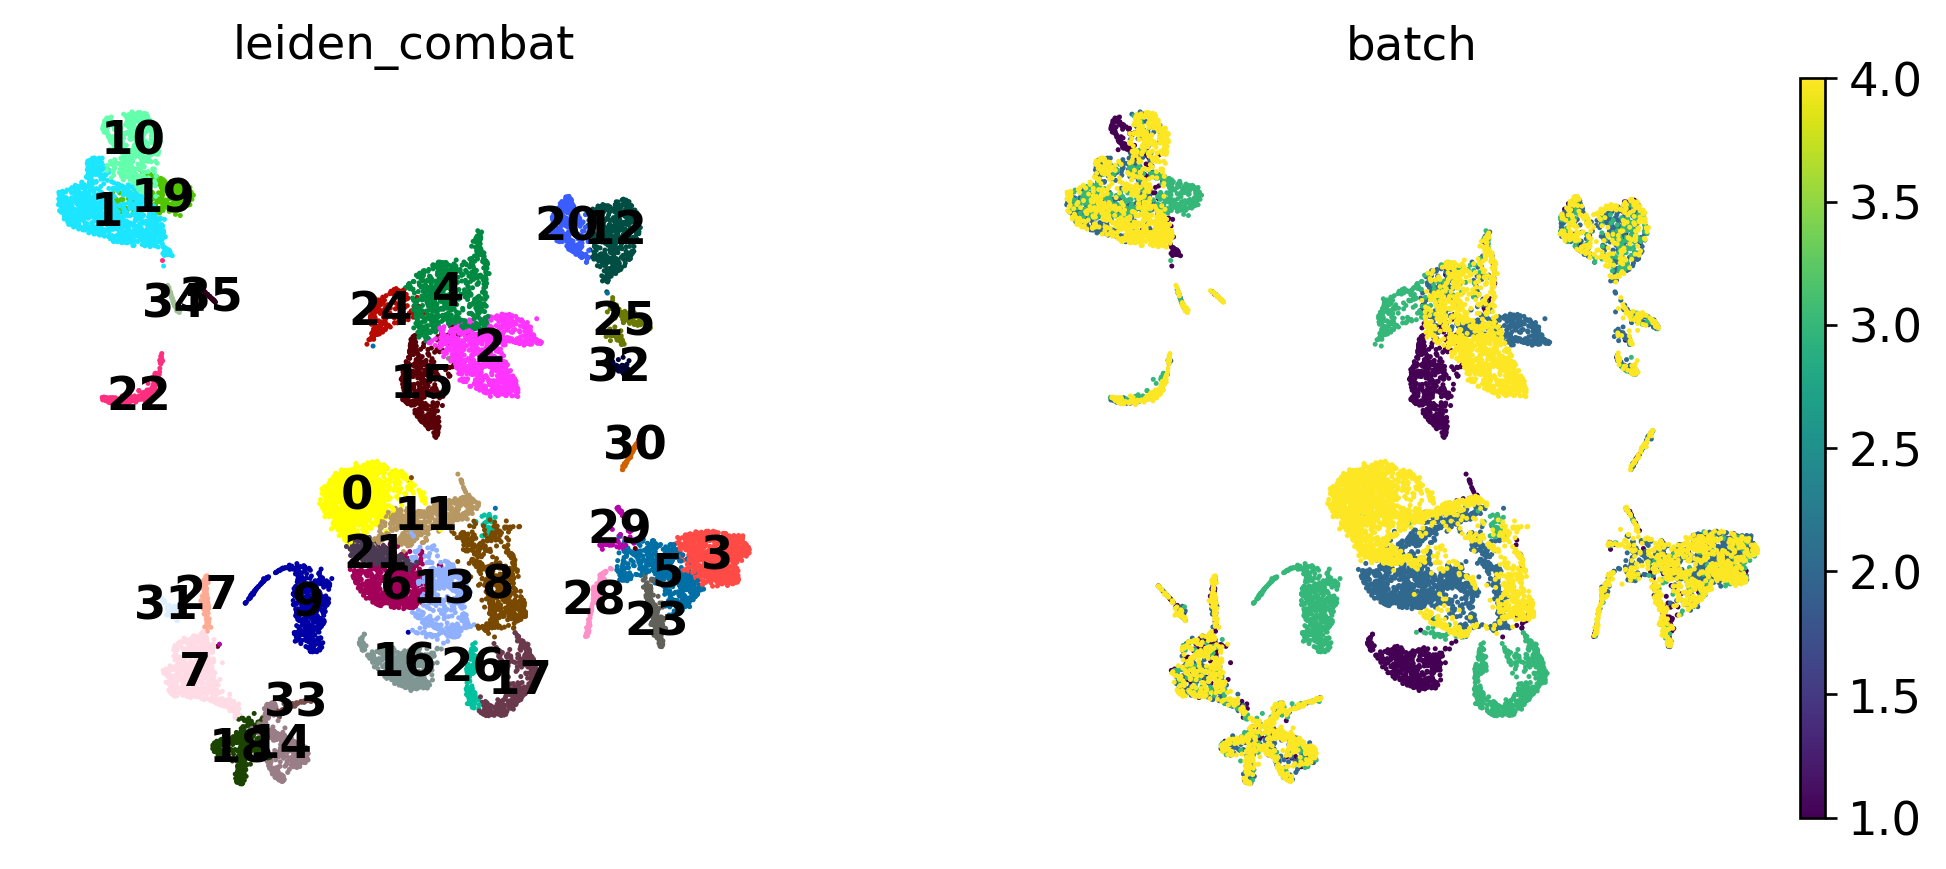

     method  silhouette  batch_entropy
0  baseline    0.149000       0.598528
1     bbknn    0.109397       0.947189
2    combat    0.092112       0.344634
Saved: figures/umap_bbknn.png, figures/umap_combat.png, figures/integration_metrics.csv


In [14]:

import sys, subprocess, importlib, math
import numpy as np, pandas as pd, scanpy as sc
from sklearn.metrics import silhouette_score

try:
    import bbknn
except Exception:
    print("BBKNN not found — installing into this kernel…")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "bbknn==1.6.0"])
    import bbknn


import scanpy.external as sce

ad_b = sc.read_h5ad("data/processed/adata_clustered.h5ad").copy()


batch_key = None
for k in ["batch","Batch","Lane","lane","Sample","sample"]:
    if k in ad_b.obs.columns:
        batch_key = k
        break
assert batch_key is not None, "No batch-like column found (batch/Batch/Lane/Sample)."


sc.pp.pca(ad_b, n_comps=50)
sce.pp.bbknn(ad_b, batch_key=batch_key, n_pcs=50, neighbors_within_batch=8)
sc.tl.umap(ad_b)
sc.tl.leiden(ad_b, resolution=1.0, key_added="leiden_bbknn")
sil_b = silhouette_score(ad_b.obsm["X_pca"][:, :20], ad_b.obs["leiden_bbknn"].astype(str))
sc.pl.umap(ad_b, color=["leiden_bbknn", batch_key], legend_loc="on data",
           frameon=False, save="_bbknn.png")
ad_b.write_h5ad("data/processed/adata_bbknn.h5ad")


ad_c = sc.read_h5ad("data/processed/adata_clustered.h5ad").copy()

try:
    import statsmodels
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "statsmodels==0.14.2"])
    import statsmodels

sc.pp.combat(ad_c, key=batch_key)
sc.pp.pca(ad_c, n_comps=50); sc.pp.neighbors(ad_c, n_neighbors=15, n_pcs=50)
sc.tl.umap(ad_c); sc.tl.leiden(ad_c, resolution=1.0, key_added="leiden_combat")
sil_c = silhouette_score(ad_c.obsm["X_pca"][:, :20], ad_c.obs["leiden_combat"].astype(str))
sc.pl.umap(ad_c, color=["leiden_combat", batch_key], legend_loc="on data",
           frameon=False, save="_combat.png")
ad_c.write_h5ad("data/processed/adata_combat.h5ad")


def batch_entropy(ad, batch_key, normalize=True):
    W = ad.obsp["connectivities"].tocsr()
    batches = ad.obs[batch_key].astype(str).values
    cats = pd.Categorical(batches).categories.tolist()
    idx = {c:i for i,c in enumerate(cats)}
    ent = np.zeros(ad.n_obs, dtype=float)
    for i in range(ad.n_obs):
        row = W.getrow(i); nbr_idx = row.indices
        if nbr_idx.size == 0:
            ent[i] = 0.0; continue
        p = np.zeros(len(cats), dtype=float)
        for j in nbr_idx:
            p[idx[batches[j]]] += 1
        p = p / p.sum()
        e = -(p[p>0] * np.log(p[p>0])).sum()
        if normalize and len(cats)>1:
            e = e / math.log(len(cats))
        ent[i] = e
    return float(ent.mean())

ad_base = sc.read_h5ad("data/processed/adata_clustered.h5ad")
base_sil = float(pd.read_csv("figures/cluster_metrics.csv")["silhouette_leiden"].iloc[0])

rows = [
    {"method":"baseline", "silhouette": base_sil, "batch_entropy": batch_entropy(ad_base, batch_key)},
    {"method":"bbknn",    "silhouette": sil_b,    "batch_entropy": batch_entropy(ad_b, batch_key)},
    {"method":"combat",   "silhouette": sil_c,    "batch_entropy": batch_entropy(ad_c, batch_key)},
]
df_int = pd.DataFrame(rows)
print(df_int)
df_int.to_csv("figures/integration_metrics.csv", index=False)
print("Saved: figures/umap_bbknn.png, figures/umap_combat.png, figures/integration_metrics.csv")

In [16]:

import scanpy as sc, pandas as pd, numpy as np, re


wx_base = pd.read_csv("data/processed/roc_markers_wilcoxon.csv")["names"].head(100).astype(str)
lr_base = pd.read_csv("data/processed/roc_markers_logreg.csv")["names"].head(100).astype(str)
base_union = set(wx_base) | set(lr_base)


adR = sc.read_h5ad("data/processed/adata_with_ROC.h5ad")
roc_cells = set(adR.obs_names[adR.obs["is_ROC"] == "ROC"])
assert len(roc_cells) > 0, "No ROC cells found in adata_with_ROC.h5ad"

def majority_roc_label(ad, cluster_key, roc_cells):
    """Return the cluster label (string) that contains the most ROC cells."""
    assert cluster_key in ad.obs, f"{cluster_key} not found in ad.obs"
    cl = ad.obs[cluster_key].astype(str)
    mask = ad.obs_names.isin(roc_cells)
    counts = cl[mask].value_counts()
    if counts.empty:

        ad.obs["is_ROC"] = np.where(ad.obs_names.isin(roc_cells), "ROC", "other")
        raise ValueError("No overlapping ROC cells in this AnnData; check obs_names consistency.")
    return counts.idxmax()

def jaccard_vs_baseline(ad, cluster_key, label_for_print):
    """Compute Jaccard of markers for the ROC-aligned cluster vs baseline union."""

    roc_label_here = majority_roc_label(ad, cluster_key, roc_cells)

    sc.tl.rank_genes_groups(ad, groupby=cluster_key, method='wilcoxon', n_genes=300)
    wx = set(sc.get.rank_genes_groups_df(ad, group=str(roc_label_here))["names"].head(100))
    sc.tl.rank_genes_groups(ad, groupby=cluster_key, method='logreg', n_genes=300, key_added="rank_logreg")
    lr = set(sc.get.rank_genes_groups_df(ad, group=str(roc_label_here), key="rank_logreg")["names"].head(100))
    uni = wx | lr
    inter = base_union & uni
    denom = (base_union | uni)
    j = len(inter) / len(denom) if len(denom) else float('nan')
    print(f"[{label_for_print}] ROC-aligned cluster = {roc_label_here}")
    print(f"ROC markers Jaccard vs baseline — {label_for_print}: {j:.3f}  (|∩|={len(inter)}, |∪|={len(denom)})")
    return j


ad_bb = sc.read_h5ad("data/processed/adata_bbknn.h5ad")
jaccard_vs_baseline(ad_bb, "leiden_bbknn", "BBKNN")


ad_cb = sc.read_h5ad("data/processed/adata_combat.h5ad")
jaccard_vs_baseline(ad_cb, "leiden_combat", "ComBat")

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: 

[BBKNN] ROC-aligned cluster = 7
ROC markers Jaccard vs baseline — BBKNN: 0.241  (|∩|=67, |∪|=278)


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: 

[ComBat] ROC-aligned cluster = 4
ROC markers Jaccard vs baseline — ComBat: 0.244  (|∩|=70, |∪|=287)


0.24390243902439024

In [22]:
import re
xls_path = "data/raw/aav9996_tables3.xlsx"
assert os.path.exists(xls_path), "Upload aav9996_tables3.xlsx to data/raw/"

def canon(g):
    if not isinstance(g,str): return None
    g = re.sub(r'\s+','', g.strip().lower())
    g = re.sub(r'(\.|-)?[ls]$','', g)
    g = re.sub(r'(\.|-)\d+$','', g)
    if g.startswith('loc'): return None
    return re.sub(r'[^a-z0-9_]','', g) or None

TOP_N = 100
wx = pd.read_csv("data/processed/roc_markers_wilcoxon.csv")['names'].head(TOP_N).astype(str)
lr = pd.read_csv("data/processed/roc_markers_logreg.csv")['names'].head(TOP_N).astype(str)
MY = {g for g in map(canon, pd.concat([wx, lr]).tolist()) if g}

xls = pd.ExcelFile(xls_path, engine="openpyxl")
S3 = set()
for sh in xls.sheet_names:
    df = xls.parse(sh, dtype=str)
    for c in df.columns:
        if re.search(r'(gene|symbol|marker|roc)', str(c), re.I) or df[c].astype(str).str.contains(r'[A-Za-z]').mean()>0.2:
            for raw in df[c].dropna().astype(str):
                for tok in re.split(r'[^A-Za-z0-9_.-]+', raw):
                    cg = canon(tok)
                    if cg: S3.add(cg)

inter = MY & S3
union = MY | S3
jacc = (len(inter)/len(union)) if union else float('nan')

os.makedirs("figures", exist_ok=True)
pd.DataFrame([{"N_my":len(MY),"N_TableS3":len(S3),"N_overlap":len(inter),"Jaccard":round(jacc,3)}]) \
  .to_csv("figures/roc_vs_tableS3_overlap.csv", index=False)
open("figures/roc_vs_tableS3_matched.txt","w").write(", ".join(sorted(inter))+"\n")

tex = rf"""
\begin{{table}}[t]
\centering
\begin{{tabular}}{{lrrrr}}
\toprule
 & \textbf{{Your ROC}} & \textbf{{Table S3}} & \textbf{{$|\cap|$}} & \textbf{{Jaccard}} \\
\midrule
ROC markers & {len(MY)} & {len(S3)} & {len(inter)} & {jacc:.3f} \\
\bottomrule
\end{{tabular}}

\medskip
\noindent\textbf{{Matched genes}} (alphabetical): {", ".join(sorted(inter))}.
\caption{{Overlap of ROC markers with Supplementary Table~3 gene list.}}
\label{{tab:roc_vs_s3}}
\end{{table}}
"""
open("figures/roc_vs_tableS3_table.tex","w").write(tex)
print("✅ Add to Overleaf:", r"\input{figures/roc_vs_tableS3_table.tex}")

✅ Add to Overleaf: \input{figures/roc_vs_tableS3_table.tex}
